## Simulation

In [1]:
import sqlite3
import simpy
import Dijkstra
import datetime
import numpy as np
from scipy.stats import lognorm, expon

# Klasse Produkt definieren - Attribute siehe DB
class Produkt:
    def __init__(self, id, bezeichnung, dlz_plan, losgroesse, bestand_rtl, bestand_ftl, bestellbestand):
        self.id = id
        self.bezeichnung = bezeichnung
        self.dlz_plan = dlz_plan
        self.losgroesse = losgroesse
        self.bestand_rtl = bestand_rtl
        self.bestand_ftl = bestand_ftl        
        self.bestellbestand = bestellbestand

# Überschreiben der __repr__ Methode, damit die Objekte als Klartext beim Printen angezeigt werden
    def __repr__(self):
        return (f"Produkt(id={self.id}, bezeichnung='{self.bezeichnung}', dlz_plan={self.dlz_plan}, "
                f"losgroesse={self.losgroesse}, bestand_rtl={self.bestand_rtl}, bestand_ftl={self.bestand_ftl})")

# Klasse Auftrag definieren - Attribute siehe DB
class Auftrag:
    def __init__(self, charge, id, menge):
        self.charge = charge
        self.id = id
        self.arbeitsplan = []
        self.menge = menge
    
    # Überschreiben der __repr__ Methode, damit die Objekte als Klartext beim Printen angezeigt werden
    def __repr__(self):
        return f"Auftrag(charge={self.charge}, id={self.id}, arbeitsplan={self.arbeitsplan})"

# Klasse FFZ definieren - Attribute siehe DB
class FFZ:
    def __init__(self, id, speed, akkulaufzeit):
        self.id = id
        self.speed = speed
        self.akkulaufzeit = akkulaufzeit
        self.akkustand = akkulaufzeit
        self.curr_location = "g"
        self.curr_transport = None
        self.queue = []
    
    # Überschreiben der __repr__ Methode, damit die Objekte als Klartext beim Printen angezeigt werden
    def __repr__(self):
        return f"Auftrag(id={self.id})"
    
# Klasse Factory definieren
class Factory:
    def __init__(self, env, db_path, start_datum, schichtregime):
        self.env = env # Simulationsumgebung
        self.db_path = db_path # Pfad zur Datenbank
        self.start_datum = start_datum
        self.schichtregime = schichtregime
        self.db() 
        env.process(self.kalender(env))
        self.lade_produkte()
        self.lade_ffz()
        self.saegen_queue = []
        self.saegen_status = "v"
        # v - verfügbar, b - belegt, d - defekt
        self.drehen_queue = []
        self.drehen_queue_intern = []
        self.drehen_1_status = "v"
        self.drehen_2_status = "v"
        self.fraesen_queue = []
        self.fraesen_status = "v"
        self.pruefen_queue = []
        self.pruefen_status = "v"
        self.transport_queue = []
        self.factory_status = True
        env.process(self.auftragserzeugung(env))
        env.process(self.absatz(env))
        env.process(self.check_factory_status(env))
        # Dijkstra
        self.graph = Dijkstra.graph([
        ("a", "b", 11), ("b", "a", 11),
        ("a", "c", 15), ("c", "a", 15),
        ("a", "d", 16), ("d", "a", 16),
        ("b", "c", 6), ("c", "b", 6),
        ("b", "d", 5), ("d", "b", 5),
        ("c", "g", 12), ("g", "c", 12),
        ("d", "e", 17), ("e", "d", 17),
        ("g", "e", 6), ("e", "g", 6),
        ("e", "f", 14), ("f", "e", 14)
        ])
        self.schichtzeiten = {
            'S1': {'start': '06:00', 'end': '14:00'}, # Ein-Schicht Regime 
            'S2': {'start': '06:00', 'end': '22:00'}, # Zwei-Schicht Regime
            'S3': {'start': '00:00', 'end': '00:00'}, # irrelevant, weil es dann keine Einschränkungen gibt
        }
        # Variable zum Speichern der aktuellen Laufzeit ohne Ausfall, dem simulierten nächsten Ausfall, der mittlere Zeit zwischen der Ausfällen und der Reparationszeit
        self.machine_param = {
            "SAE": {'sum_workload': 50, 'next_failure': 500, 'mean_runtime': 960, 'maintenance_time': 60},
            "DRH1": {'sum_workload': 450, 'next_failure': 900, 'mean_runtime': 1100, 'maintenance_time': 90},
            "DRH2": {'sum_workload': 200, 'next_failure': 1300, 'mean_runtime': 900, 'maintenance_time': 75},
            "FRA": {'sum_workload': 700, 'next_failure': 1100, 'mean_runtime': 880, 'maintenance_time': 45},
        }

    # DB Verbindung herstellen
    def db(self):
        self.conn = sqlite3.connect(self.db_path)
        self.cursor = self.conn.cursor()

    # Kalender Aktualisierung
    def kalender(self, env):
        while True:
            self.uhrzeit = start_datum + datetime.timedelta(minutes=env.now)
            #self.uhrzeit = self.uhrzeit.strftime("%Y-%m-%d %H:%M:%S")
            yield env.timeout(1)  

    def check_factory_status(self, env):    
        while True:
            # bestimme aktuelle Zeit
            aktuelle_uhrzeit = self.uhrzeit.strftime("%H:%M")

            # Wochentag bestimmen (0 = Montag, ..., 6 = Sonntag)
            wochentag = self.uhrzeit.weekday()

            # Überprüfen, ob es ein Wochenende ist (Samstag oder Sonntag)
            if wochentag == 5 or wochentag == 6:  # 5 = Samstag, 6 = Sonntag
                self.factory_status = False
            else:
                if self.schichtregime == 'S1':
                    if self.schichtzeiten['S1']['start'] <= aktuelle_uhrzeit <= self.schichtzeiten['S1']['end']:
                        self.factory_status = True
                    else:
                        self.factory_status = False
                elif self.schichtregime == 'S2':
                    if self.schichtzeiten['S2']['start'] <= aktuelle_uhrzeit <= self.schichtzeiten['S2']['end']:
                        self.factory_status = True
                    else:
                        self.factory_status = False

            yield env.timeout(1)

    # Funktion die Überprüft, ob ein Arbeitsschritt bzw. ein Transport ausgeführt werden kann, ohne eine Arbeitszeitüberschreitung zu verursachen
    def check_for_soon_shotdown(self, timeout, env):
        
        if self.schichtregime == 'S1':
            while ((self.uhrzeit + datetime.timedelta(minutes=timeout)).strftime("%H:%M") >= self.schichtzeiten['S1']['end']) or (
            (self.uhrzeit.strftime("%H:%M") <= self.schichtzeiten['S1']['start']) or (
             (self.uhrzeit + datetime.timedelta(minutes=timeout)).strftime("%H:%M") <= self.schichtzeiten['S1']['start'])):
                yield env.timeout(1)
            
        elif self.schichtregime == 'S2':
            while ((self.uhrzeit + datetime.timedelta(minutes=timeout)).strftime("%H:%M") >= self.schichtzeiten['S2']['end']) or (
            (self.uhrzeit.strftime("%H:%M") <= self.schichtzeiten['S2']['start']) or (
             (self.uhrzeit + datetime.timedelta(minutes=timeout)).strftime("%H:%M") <= self.schichtzeiten['S2']['start'])):
                yield env.timeout(1)

    # Funktion welche die Zeiten der Bearbeitungsvorgänge simuliert
    def run_time(self, arbeitsschritt, auftrag, bmg, env):
        ausschussrate = {
            "SAE": 0.005,
            "DRH1": 0.01,
            "DRH2": 0.008,
            "FRA": 0.01,
            "QPR": 0
        }

        # Überprüfen von Fehlerzuständen 
        if bmg != "QPR":
            yield env.process(self.check_down_time(bmg, env))

        # Rüstvorgang
        yield env.process(self.check_for_soon_shotdown(arbeitsschritt[1], env))
        start_ruesten = self.uhrzeit
        
        # Ziehen der tatsächlichen Rüstzeit
        # Gegebene Parameter für die Log-Normalverteilung
        M = arbeitsschritt[1]  # Mittelwert der Log-Normalverteilung
        sigma_L = M / 15  # Standardabweichung der Log-Normalverteilung -> 6,67 % der Bearbeitungszeit

        # Berechne die Parameter der zugrunde liegenden Normalverteilung
        sigma = np.sqrt(np.log(1 + (sigma_L**2 / M**2)))  # Standardabweichung der Normalverteilung
        mu = np.log(M) - 0.5 * sigma**2  # Mittelwert der Normalverteilung

        # Ziehe einen zufälligen Wert aus der Log-Normalverteilung
        zeit = lognorm.rvs(sigma, scale=np.exp(mu), size=1)     
        yield env.timeout(zeit[0])  # Rüstzeit

        # Bearbeitungsvorgang
        yield env.process(self.check_for_soon_shotdown(arbeitsschritt[2], env))
        start_bearbeitung = self.uhrzeit

        # Ziehen der tatsächlichen Rüstzeit
        # Gegebene Parameter für die Log-Normalverteilung
        M = arbeitsschritt[2]  # Mittelwert der Log-Normalverteilung
        sigma_L = M / 15  # Standardabweichung der Log-Normalverteilung -> 6,67 % der Bearbeitungszeit

        # Berechne die Parameter der zugrunde liegenden Normalverteilung
        sigma = np.sqrt(np.log(1 + (sigma_L**2 / M**2)))  # Standardabweichung der Normalverteilung
        mu = np.log(M) - 0.5 * sigma**2  # Mittelwert der Normalverteilung

        # Ziehe einen zufälligen Wert aus der Log-Normalverteilung
        zeit = lognorm.rvs(sigma, scale=np.exp(mu), size=1)     

        yield env.timeout(zeit[0])  # Bearbeitungszeit
        ende_bearbeitung = self.uhrzeit  

        if bmg != "QPR":
            self.machine_param[bmg]['sum_workload'] += zeit[0]

        ausschuss = int(np.random.binomial(auftrag.menge, ausschussrate[bmg], 1)[0])
        auftrag.menge -= ausschuss

        # Einträge in DB pflegen
        self.cursor.execute('INSERT INTO FLF (Charge, bmg, start_ruesten, start_bearbeitung, ende_bearbeitung, anzahl_bauteile, ausschuss) VALUES (?, ?, ?, ?, ?, ?, ?)', 
                            (auftrag.charge, bmg, start_ruesten, start_bearbeitung, ende_bearbeitung, int(auftrag.menge), ausschuss))
        self.conn.commit()

    def check_down_time(self, bmg, env):
        if self.machine_param[bmg]['sum_workload'] >= self.machine_param[bmg]['next_failure']:
            start_down_time = self.uhrzeit
            
            yield env.timeout(self.machine_param[bmg]['maintenance_time'])
            self.machine_param[bmg]['sum_workload'] = 0

            end_down_time = self.uhrzeit

            # Einträge in DB pflegen
            self.cursor.execute('INSERT INTO ELF (bmg, start_downtime, end_downtime) VALUES (?, ?, ?)', 
                            (bmg, start_down_time, end_down_time))
            self.conn.commit()

            # next down time
            next_down_time = expon.rvs(scale=self.machine_param[bmg]['mean_runtime'], size=1)[0]
            self.machine_param[bmg]['next_failure'] = next_down_time

        

    # Erstelle Produkt Objekte auf Basis der Produktstammdaten siehe db
    def lade_produkte(self):
        self.produkte = []

        # Produkte aus der Tabelle produktstammdaten abrufen
        self.cursor.execute('SELECT * FROM produktstammdaten')
        rows = self.cursor.fetchall()

        # Für jede Zeile ein Produkt-Objekt erstellen
        for row in rows:
            produkt = Produkt(id=row[0], bezeichnung=row[1], dlz_plan=row[2], losgroesse=row[3], bestand_rtl=row[4], bestand_ftl=row[5], bestellbestand=row[6])
            self.produkte.append(produkt)
            # Name des Objekts entspricht der Bezeichnung
            globals()[produkt.bezeichnung] = produkt

    def lade_ffz(self):
        self.ffzs = []

        self.cursor.execute('SELECT * FROM ffz')
        rows = self.cursor.fetchall()

        for row in rows:
            ffz = FFZ(id=row[0], speed=row[1], akkulaufzeit=row[2])
            self.ffzs.append(ffz)    

    # Finde Source und Destination des Transports
    def find_source_destination(self, arbeitsschritt, folgeschritt):
        # Dictionary mit den Standorten der Arbeitsstationen
        location_map = {
            'RTL': 'a',  # RTL an Standort A
            'SAE': 'b',  # Sägen an Standort B
            'DRH': 'c',  # Drehen an Standort C
            'FRA': 'd',  # Fräsen an Standort D
            'QPR': 'e',  # Prüfen an Standort D
            'FTL': 'f',  # Fertigteillager an Standort E
        }

        # Bestimme den Standort für den aktuellen Arbeitsschritt
        if arbeitsschritt is not None:
            source = location_map.get(arbeitsschritt[0])
        else: 
            source = location_map.get('RTL')

        if folgeschritt is not None:
            destination = location_map.get(folgeschritt[0])
        else:
            destination = location_map.get('FTL')

        return source, destination


    # Einfachster Fall Bestellbestands-Verfahren - Erzeugung neuer Aufträge bei Unterschreitung der Bestellbestands
    def auftragserzeugung(self, env):
        self.auftraege = []
        self.freigabe_liste = []
        while True: # Erzeugungs-Prüflauf läuft kontinuierlich
            for produkt in self.produkte:
                # Berechne die Summe der Mengen aller Aufträge für das Produkt (Lagerbestand + Summe offene Aufträge)
                offene_auftragsmenge = sum(auftrag.menge for auftrag in self.auftraege if auftrag.id == produkt.id)
                
                while (produkt.bestand_ftl + offene_auftragsmenge) < produkt.bestellbestand:
                    # Auftrag in die Datenbank einfügen
                    self.cursor.execute('INSERT INTO auftraege (id, stueckzahl_plan) VALUES (?, ?)', (produkt.id, produkt.losgroesse))

                    # Abrufen der Charge für den letzten eingefügten Auftrag
                    self.cursor.execute('SELECT charge FROM auftraege ORDER BY charge DESC LIMIT 1')
                    charge = self.cursor.fetchone()[0]  

                    # Erstellen eines Auftrag-Objekts
                    auftrag = Auftrag(charge=charge, id=produkt.id, menge=produkt.losgroesse)
                    
                    # Suche nach den Arbeitsschritten
                    self.cursor.execute('SELECT bmg, r_plan, t_plan, nr FROM arbeitsplaene WHERE id=? ORDER BY nr ASC', (produkt.id,))
                    rows = self.cursor.fetchall()  
                    
                    # Alle Arbeitsplan-Einträge zum Auftrag hinzufügen
                    for row in rows:
                        auftrag.arbeitsplan.append(row) 

                    # Speichern des Auftrag-Objekts in der Liste
                    self.auftraege.append(auftrag)
                    self.freigabe_liste.append(auftrag)

                    # Auftrag freigeben und als Prozess starten
                    env.process(self.auftragsfreigabe(auftrag, produkt, env))

                    # Commit
                    self.conn.commit()

                    # Aktualisiere die offene Auftragsmenge für die nächste Schleife
                    offene_auftragsmenge = sum(auftrag.menge for auftrag in self.auftraege if auftrag.id == produkt.id)

                    yield env.timeout(0)
            yield env.timeout(1)         
    
    # Berechnet den Bestand in (ZE) an dem Durchsatzengpass
    def bestand_engpass(self):
        """Berechnet die Summe aller Rüst- und Bearbeitungszeiten für Aufträge in der drehen_queue."""
        total_ruestzeit = 0
        total_bearbeitungszeit = 0

        # Iteriere über alle Aufträge in der drehen_queue
        for auftrag in self.drehen_queue:
            for arbeitsschritt in auftrag.arbeitsplan:
                # Prüfen, ob der Arbeitsschritt zu 'DRH' (Drehen) gehört
                if arbeitsschritt[0] == 'DRH':
                    total_ruestzeit += arbeitsschritt[1]
                    total_bearbeitungszeit += arbeitsschritt[2]

        gesamtzeit = total_ruestzeit + total_bearbeitungszeit
        return gesamtzeit

    # Auftragsfreigabe, bei Unterschreitung des Planbestands am Durchsatz Engpass (hier DRH) 
    def auftragsfreigabe(self, auftrag, produkt, env):
        """Führt die Produktionsschritte für einen gegebenen Auftrag durch.
        Args:
        auftrag: Das Auftrag-Objekt, das die Arbeitspläne enthält.
        produkt: Das Produkt, das bearbeitet wird.
        env: Die SimPy-Umgebung, die die Simulation verwaltet.
        """       
        status = False
        
        # kontinuierliche Prüfung der Freigabekriterien 
        while status == False:
            while self.factory_status == False:
                
                yield env.timeout(1)
            
            self.bestand_am_engpass = self.bestand_engpass() # aktualisiert den bestand am Engpass
            
            # gibt Auftrag frei, wenn der Auftrag den Engpass durchläuft, der Auftrag der erste der liste ist und der Bestand am Engpass den Planbestand unterschreitet
            if self.freigabe_liste[0] == auftrag and self.bestand_am_engpass < 200 and any(step[0] == 'DRH' for step in auftrag.arbeitsplan):
                status = True
                self.freigabe_liste.remove(auftrag)
            
            # Aufträge nicht über den Engpass laufen werden sofort freigegeben 
            elif not any(step[0] == 'DRH' for step in auftrag.arbeitsplan):
                status = True
                self.freigabe_liste.remove(auftrag)

            else:
                yield env.timeout(1)
        
        # Freigabe in DB pflegen
        self.cursor.execute('''UPDATE auftraege SET freigabe = ? WHERE Charge = ?''', 
                                (self.uhrzeit, auftrag.charge))
        self.conn.commit()

        # Stationen
        workstations = {
            'SAE': self.saegen,
            'DRH': self.drehen,
            'QPR': self.pruefen,
            'FRA': self.fraesen,
        }

        # Queues
        queues = {
            'SAE': self.saegen_queue,
            'DRH': self.drehen_queue,
            'QPR': self.pruefen_queue,
            'FRA': self.fraesen_queue,
        }

        # Zuordnung der Queues nach erfolgreicher Auftragsfreigabe
        for arbeitsschritt in auftrag.arbeitsplan:
        # Hole die Bearbeitungsfunktion und Queue der entsprechenden Arbeitsstation
            station_queue = queues.get(arbeitsschritt[0])

            # Füge den Auftrag der Queue der Station hinzu
            station_queue.append(auftrag)

        # Auftragsfreigabe in DB protokollieren 

        # Eintrag in DB zur Protokollierung des Lagereingangs
        freigabe = self.uhrzeit
        self.cursor.execute('INSERT INTO FLF (ankunft, charge, bmg) VALUES (?, ?, ?)', 
                          (freigabe, auftrag.charge, 'RTL'))
        self.conn.commit()

        for i, arbeitsschritt in enumerate(auftrag.arbeitsplan):
            # Transport aus RTL für 1. Arbeitsschritt
            if arbeitsschritt == auftrag.arbeitsplan[0]:
                # Bestimme Source und Destination
                source, destination = self.find_source_destination(None, arbeitsschritt)
                # Transport
                yield env.process(self.transport(auftrag, source, destination, arbeitsschritt, env))
                ankunft = self.uhrzeit
            else: # Ankunft aller anderen Aufträge
                ankunft = self.uhrzeit

            # Start Bearbeitungsprozess            
            yield env.process(workstations.get(arbeitsschritt[0])(auftrag, arbeitsschritt, env))

            # Nächster Arbeitsschritt (falls vorhanden)
            folgeschritt = auftrag.arbeitsplan[i + 1] if i + 1 < len(auftrag.arbeitsplan) else None
  
            # Bestimme Source und Destination
            source, destination = self.find_source_destination(arbeitsschritt, folgeschritt)

            # Transport 
            yield env.process(self.transport(auftrag,source, destination, arbeitsschritt, env))

            # Einträge in DB pflegen
            self.cursor.execute('''UPDATE FLF SET ankunft = ? WHERE Charge = ? AND bmg like ?''', 
                                (ankunft, auftrag.charge, arbeitsschritt[0] + '%'))
            self.conn.commit()

            # Falls der letzte Arbeitsschritt ausgeführt wurde:
            if arbeitsschritt == auftrag.arbeitsplan[-1]:
                # Auftrag aus Auftragsliste entfernen
                self.auftraege.remove(auftrag)
                            
                # Bestand um die Losgröße erhöhen
                produkt.bestand_ftl += produkt.losgroesse

                # Bestand des Produkts in der Datenbank aktualisieren
                self.cursor.execute('UPDATE produktstammdaten SET bestand_ftl = ? WHERE id = ?', (produkt.bestand_ftl, produkt.id))
                # Eintrag in DB zur Protokollierung des Lagereingangs
                ankunft_ftl = self.uhrzeit
                self.cursor.execute('INSERT INTO FLF (ankunft, charge, bmg) VALUES (?, ?, ?)', 
                        (ankunft_ftl, auftrag.charge, 'FTL'))
                
                # Bearbeitungsenge in DB pflegen
                self.cursor.execute('''UPDATE auftraege SET fertigstellung = ?, stueckzahl_ist = ? WHERE Charge = ?''', 
                                (self.uhrzeit, auftrag.menge, auftrag.charge))
                self.conn.commit()

                self.conn.commit()
          

    ##### Produktionsfunktionen
    def saegen(self, auftrag, arbeitsschritt, env):
        # Prüfen ob die Maschine belegt ist       
        while self.saegen_status == ("b" or "d") or self.saegen_queue[0] != auftrag:
            yield env.timeout(1)
        
        # Status belegt, bei Start der Bearbeitung
        self.saegen_status = "b"

        # Simulation der Bearbeitungszeiten
        yield env.process(self.run_time(arbeitsschritt, auftrag, arbeitsschritt[0], env))

        # Status verfügbar, bei Ende der Bearbeitung
        self.saegen_status = "v"

        # Entferne den Auftrag nach der Bearbeitung aus der Warteschlange
        self.saegen_queue.remove(auftrag)

    def drehen(self, auftrag, arbeitsschritt, env):
        # Aufbau der weiteren Produktionsfunktionen analog der ersten
        # Besonderheit beim Drehen: 2 Arbeitssysteme        
        # Füge Auftrag zur internen Queue hinzu
        self.drehen_queue_intern.append(auftrag)
        
        while (self.drehen_1_status == ("b" or "d") and self.drehen_2_status == ("b" or "d")) or self.drehen_queue_intern[0] != auftrag:
            yield env.timeout(1)

        if self.drehen_1_status == "v":

            self.drehen_1_status = "b"

            # Entferne Auftrag aus interner Queue
            self.drehen_queue_intern.remove(auftrag)

            # Simulation der Bearbeitungszeiten
            yield env.process(self.run_time(arbeitsschritt, auftrag, "DRH1", env))

            # Entferne den Auftrag nach der Bearbeitung aus der Warteschlange
            self.drehen_queue.remove(auftrag)

            self.drehen_1_status = "v"

        elif self.drehen_2_status == "v":

            self.drehen_2_status = "b"

            # Entferne Auftrag aus interner Queue
            self.drehen_queue_intern.remove(auftrag)

            # Simulation der Bearbeitungszeiten
            yield env.process(self.run_time(arbeitsschritt, auftrag, "DRH2", env))

            # Entferne den Auftrag nach der Bearbeitung aus der Warteschlange
            self.drehen_queue.remove(auftrag)

            self.drehen_2_status = "v"

    def fraesen(self, auftrag, arbeitsschritt, env):
        # Prüfen ob die Maschine belegt ist
        while self.fraesen_status == ("b" or "d") or self.fraesen_queue[0] != auftrag:
            yield env.timeout(1)
        
        # Status belegt, bei Start der Bearbeitung
        self.fraesen_status = "b"

        # Simulation der Bearbeitungszeiten
        yield env.process(self.run_time(arbeitsschritt, auftrag, arbeitsschritt[0], env))
        
        # Status verfügbar, bei Ende der Bearbeitung
        self.fraesen_status = "v"

        # Entferne den Auftrag nach der Bearbeitung aus der Warteschlange
        self.fraesen_queue.remove(auftrag)
           
    def pruefen(self, auftrag, arbeitsschritt, env):
        # prüfen ob die Maschine belegt ist
        while self.pruefen_status == ("b" or "d") or self.pruefen_queue[0] != auftrag:
            yield env.timeout(1)
        
        self.pruefen_status = "b"
        
        # Simulation der Bearbeitungszeiten
        yield env.process(self.run_time(arbeitsschritt, auftrag, arbeitsschritt[0], env))

        self.pruefen_status = "v"

        # Entferne den Auftrag nach der Bearbeitung aus der Warteschlange
        self.pruefen_queue.remove(auftrag)

    ##### Transportfunktionen
    def transport(self, auftrag, source, destination, arbeitsschritt, env):
        status = False
        self.transport_queue.append(auftrag)

        # Fortlaufende Überprüfung ob FFZ verfügbar ist
        while status == False:
            for ffz in self.ffzs:
                if ffz.curr_transport == None and self.transport_queue[0] == auftrag:
                    self.transport_queue.remove(auftrag)

                    # Zuweisen des Auftrags zu FFZ
                    ffz.curr_transport = auftrag

                    # Berechnung der Distance des FFZs zur Source mit Dijkstra Algorithmus
                    distance_to_source = self.graph.dijkstra(ffz.curr_location, source)[1] # self.graph.dijkstra("a", "d")[0] für gewählte Route
                    route_to_source = self.graph.dijkstra(ffz.curr_location, source)[0]
                    route_as_string = '->'.join(route_to_source)

                    # Berechnung der Fahrdauer zur Source
                    duration_to_source = distance_to_source * 10 / ffz.speed

                    # Energieverbrauch
                    ffz.akkustand -= distance_to_source
                    if distance_to_source > 0:
                        # Fahrt zur Source 
                        yield env.process(self.check_for_soon_shotdown(duration_to_source, env))
                        yield env.timeout(duration_to_source)
                        
                        # Fahrt in TLF eintragen
                        self.cursor.execute('INSERT INTO TLF (FFZ_id, start_knoten, end_knoten, route, startzeitpunkt, endzeitpunkt, akkustand) VALUES (?, ?, ?, ?, ?, ?, ?)', 
                                (ffz.id, ffz.curr_location, source, route_as_string, self.uhrzeit - datetime.timedelta(minutes=duration_to_source), self.uhrzeit, ffz.akkustand/ffz.akkulaufzeit))

                    # Abtransport in FLT pflegen
                    abtransport = self.uhrzeit
                    self.cursor.execute('''UPDATE FLF SET abtransport = ? WHERE Charge = ? AND bmg like ?''', 
                                        (abtransport, auftrag.charge, arbeitsschritt[0] + '%'))
                    self.conn.commit()
                   
                    # Berechnung der Distance zur Destination
                    distance_to_destination = self.graph.dijkstra(source, destination)[1] # self.graph.dijkstra("a", "d")[0] für gewählte Route
                    route_to_destination = self.graph.dijkstra(source, destination)[0]
                    route_as_string = '->'.join(route_to_destination)
                    # Berechnung der Fahrdauer zur Destination
                    duration_to_destination = distance_to_destination * 10 / ffz.speed
                    
                    # Energieverbrauch
                    ffz.akkustand -= distance_to_destination

                    # Fahrt zur Destination
                    yield env.process(self.check_for_soon_shotdown(duration_to_destination, env))
                    yield env.timeout(duration_to_destination)
                    ffz.curr_location = destination

                    # Fahrt in TLF eintragen
                    self.cursor.execute('INSERT INTO TLF (FFZ_id, start_knoten, end_knoten, route,startzeitpunkt, endzeitpunkt, akkustand, charge) VALUES (?, ?, ?, ?, ?, ?, ?, ?)', 
                            (ffz.id, source, destination, route_as_string, self.uhrzeit - datetime.timedelta(minutes=duration_to_destination), self.uhrzeit, ffz.akkustand/ffz.akkulaufzeit, auftrag.charge))

                    # Prüfe nach jeder abgeschlossenen Transportaufgabe, ob die Akkuladung noch ausreicht
                    if ffz.akkustand < 0.25 * ffz.akkulaufzeit:
                        yield env.process(self.ladevorgang(ffz, env))


                    # Zurücksetzen der Stati
                    ffz.curr_transport = None
                    status = True

                    break
                else:
                    continue
            yield env.timeout(1)

    # Ladevorgang FFZ
    def ladevorgang(self, ffz, env):
        # Berechnung der Distance des FFZs zur Source mit Dijkstra Algorithmus
        distance_to_station = self.graph.dijkstra(ffz.curr_location, "g")[1] # self.graph.dijkstra("a", "d")[0] für gewählte Route
        route_to_station = self.graph.dijkstra(ffz.curr_location, "g")[0]
        route_as_string = '->'.join(route_to_station)          
        # Berechnung der Fahrdauer zur Source
        duration_to_station = distance_to_station * 10 / ffz.speed

        # Energieverbrauch
        ffz.akkustand -= distance_to_station
        
        # Fahrt zur Station
        yield env.process(self.check_for_soon_shotdown(duration_to_station, env))
        yield env.timeout(duration_to_station)

        # Fahrt in TLF eintragen
        self.cursor.execute('INSERT INTO TLF (FFZ_id, start_knoten, end_knoten, route, startzeitpunkt, endzeitpunkt, akkustand) VALUES (?, ?, ?, ?, ?, ?, ?)', 
                            (ffz.id, ffz.curr_location, 'g', route_as_string,self.uhrzeit - datetime.timedelta(minutes=duration_to_station), self.uhrzeit, ffz.akkustand/ffz.akkulaufzeit))
        
        # Ladevorgang an sich 
        yield env.timeout((ffz.akkulaufzeit - ffz.akkustand) / 10)
        ffz.akkustand = ffz.akkulaufzeit

        ffz.curr_location = "g"

    # Absatzfunktion
    def absatz(self, env):
        while True:
            while self.factory_status == False:
                yield env.timeout(1)
            
            for produkt in self.produkte:
                produkt.bestand_ftl -= 100
            
            yield env.timeout(150)

In [2]:
# Simulation starten
start_datum = datetime.datetime(2024, 1, 1, 0, 0)

env = simpy.Environment()

#Factory-Instanz erstellen und die Datenbank laden
factory = Factory(env, 'prod_data.db', start_datum, 'S2')
env.run(until=10000)

In [3]:
# Verbindung zur bestehenden Datenbank herstellen
conn = sqlite3.connect('prod_data.db')
cursor = conn.cursor()

# Abfrage, um alle Tabellen in der Datenbank anzuzeigen
cursor.execute('''
    SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';
''')

# Alle Tabellen auflisten
tables = cursor.fetchall()

# Für jede Tabelle den Inhalt anzeigen
for table in tables:
    table_name = table[0]
    print(f"Inhalt der Tabelle: {table_name}")
    
    # Inhalt der Tabelle abfragen
    cursor.execute(f'SELECT * FROM {table_name}')
    rows = cursor.fetchall()
    
    # Spaltennamen der Tabelle anzeigen
    column_names = [description[0] for description in cursor.description]
    print(column_names)  # Spaltennamen drucken
    
    # Inhalt der Tabelle Zeile für Zeile drucken
    for row in rows:
        print(row)
    print("\n" + "-"*50 + "\n")  # Trennlinie für bessere Lesbarkeit

# Verbindung schließen
conn.close()

Inhalt der Tabelle: produktstammdaten
['id', 'bezeichnung', 'dlz_plan', 'losgroesse', 'Bestand_RTL', 'Bestand_FTL', 'Bestellbestand']
('A2', 'Deckel', 150, 50, 1000, -250, 1500)
('A7', 'Welle', 50, 200, 1000, 0, 1700)
('A1', 'Gehause', 50, 100, 1000, 1400, 1300)

--------------------------------------------------

Inhalt der Tabelle: auftraege
['Charge', 'id', 'stueckzahl_plan', 'stueckzahl_ist', 'freigabe', 'fertigstellung']
(20000000, 'A2', 50, 50, '2024-01-01 06:00:00', '2024-01-01 09:59:00')
(20000001, 'A2', 50, 49, '2024-01-01 06:00:00', '2024-01-01 10:41:00')
(20000002, 'A2', 50, 50, '2024-01-01 06:00:00', '2024-01-01 11:22:00')
(20000003, 'A2', 50, 49, '2024-01-01 08:27:00', '2024-01-01 18:10:00')
(20000004, 'A2', 50, 50, '2024-01-01 09:06:00', '2024-01-01 20:31:00')
(20000005, 'A2', 50, 50, '2024-01-01 09:41:00', '2024-01-01 20:40:00')
(20000006, 'A2', 50, 49, '2024-01-01 13:40:00', '2024-01-02 06:25:00')
(20000007, 'A2', 50, 50, '2024-01-01 16:32:00', '2024-01-02 08:31:00')
(2

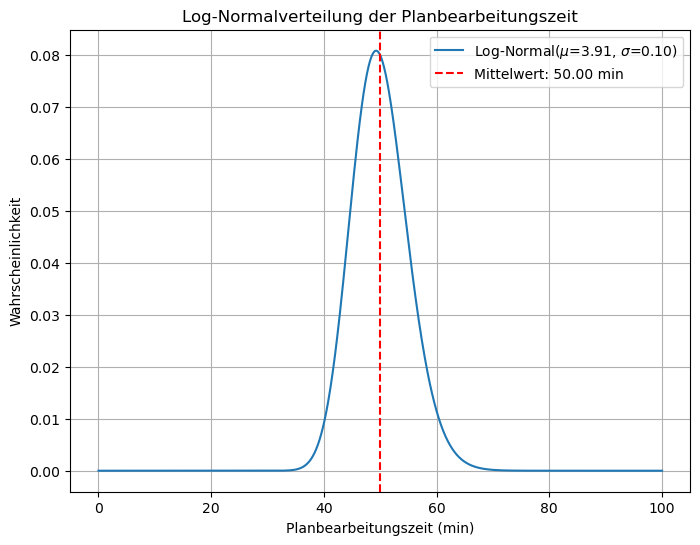

Berechneter Mittelwert der Normalverteilung (mu): 3.91
Berechnete Standardabweichung der Normalverteilung (sigma): 0.10
Mittelwert der Log-Normalverteilung: 50.00


In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# Gegebene Planbearbeitungszeit (Mittelwert und Standardabweichung)
mu_T = 50  # Mittelwert der Planbearbeitungszeit (Log-Normalverteilung)
sigma_T = 5  # Standardabweichung der Planbearbeitungszeit (Log-Normalverteilung)

# Berechne die Parameter der zugrunde liegenden Normalverteilung
# Umkehrung der Formeln für die Log-Normalverteilung:
sigma = np.sqrt(np.log(1 + (sigma_T / mu_T)**2))  # Standardabweichung der Normalverteilung
mu = np.log(mu_T) - 0.5 * sigma**2  # Mittelwert der Normalverteilung

# Berechne den Mittelwert der Log-Normalverteilung
mean_lognorm = np.exp(mu + 0.5 * sigma**2)

# Generiere Daten für den Plot
x = np.linspace(0, 100, 1000)  # Werte für die X-Achse (Planbearbeitungszeit)
y = lognorm.pdf(x, sigma, scale=np.exp(mu))  # Berechnung der Wahrscheinlichkeitsdichtefunktion

# Plot erstellen
plt.figure(figsize=(8, 6))
plt.plot(x, y, label=f'Log-Normal($\mu$={mu:.2f}, $\sigma$={sigma:.2f})')
plt.axvline(mean_lognorm, color='r', linestyle='--', label=f'Mittelwert: {mean_lognorm:.2f} min')  # Mittelwert einzeichnen
plt.title('Log-Normalverteilung der Planbearbeitungszeit')
plt.xlabel('Planbearbeitungszeit (min)')
plt.ylabel('Wahrscheinlichkeit')
plt.legend()
plt.grid(True)
plt.show()

# Ausgabe der berechneten Parameter
print(f"Berechneter Mittelwert der Normalverteilung (mu): {mu:.2f}")
print(f"Berechnete Standardabweichung der Normalverteilung (sigma): {sigma:.2f}")
print(f"Mittelwert der Log-Normalverteilung: {mean_lognorm:.2f}")


